PHASE 1

In [2]:
import pandas as pd
df = pd.read_csv("C:\\Users\\skapi\\Desktop\\report\\IPL_Bowler_Detailed_Data.csv")
df.shape  
df.head()


,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket
0,29504,12-Apr-23,Neutral,Powerplay,1,1,Bowler B,17.97,133.25,0,1
1,96402,30-Nov-23,Batting,Powerplay,5,1,Bowler A,20.51,119.98,0,0
2,27383,07-Nov-22,Neutral,Powerplay,1,5,Bowler B,30.05,124.73,2,0
3,99624,10-Apr-22,Batting,Powerplay,5,3,Bowler B,21.29,147.69,1,0
4,65569,23-Jun-23,Neutral,Powerplay,5,3,Bowler B,34.89,117.51,0,0


In [3]:
df['Is_Dot_Ball'] = (df['Runs_Conceded'] == 0).astype(int)
print(df)


      Match_ID Match_Date Pitch_Type      Phase  Over  Ball    Bowler  \
0        29504  12-Apr-23    Neutral  Powerplay     1     1  Bowler B   
1        96402  30-Nov-23    Batting  Powerplay     5     1  Bowler A   
2        27383  07-Nov-22    Neutral  Powerplay     1     5  Bowler B   
3        99624  10-Apr-22    Batting  Powerplay     5     3  Bowler B   
4        65569  23-Jun-23    Neutral  Powerplay     5     3  Bowler B   
...        ...        ...        ...        ...   ...   ...       ...   
4795     18611  15-Jul-23    Bowling  Powerplay     3     6  Bowler B   
4796     48165  22-Sep-22    Neutral  Powerplay     3     4  Bowler A   
4797     39550  06-Jun-23    Neutral  Powerplay     1     3  Bowler A   
4798     69821  08-Mar-23    Neutral      Death    19     6  Bowler B   
4799     33478  24-Jun-22    Batting      Death    19     4  Bowler A   

      Batter_Avg  Batter_SR  Runs_Conceded  Is_Wicket  Is_Dot_Ball  
0          17.97     133.25              0          1 

In [4]:
df['Is_Death'] = df['Over'].between(16,20)


In [5]:
df['Is_Last_Ball'] = (df['Ball'] == 6)
df['Pressure'] = ((df['Is_Dot_Ball']==1)&(df['Is_Death'])&(~df['Is_Last_Ball'])).astype(int)
df['Prev_Pressure'] = df.groupby(['Match_ID','Bowler'])['Pressure'].shift(1).fillna(0)
df['Next_Ball_Wicket'] = df.groupby(['Match_ID','Bowler'])['Is_Wicket'].shift(-1).fillna(0)
df_death = df[df['Is_Death']]
df_death = df_death.copy()

mean = df_death['Batter_Avg'].mean()
std = df_death['Batter_Avg'].std()
df_death['Batter_Avg_std'] = (df_death['Batter_Avg'] - mean)/std



In [6]:
pd.get_dummies(df_death['Pitch_Type'], drop_first=True)

,Bowling,Neutral
11,False,True
14,False,True
18,False,False
19,False,False
20,False,True
...,...,...
4790,False,False
4792,False,False
4793,False,True
4798,False,True


In [7]:
df_death['Bowler_A_flag'] = (df_death['Bowler']=="A").astype(int)
df_death['PrevPressure_x_BowlerA'] = df_death['Prev_Pressure'] * df_death['Bowler_A_flag']
df_death.groupby('Bowler')['Is_Wicket'].mean()
df_death[df_death['Prev_Pressure']==1].groupby('Bowler')['Is_Wicket'].mean()


Bowler
Bowler A    0.041885
Bowler B    0.179348
Name: Is_Wicket, dtype: float64

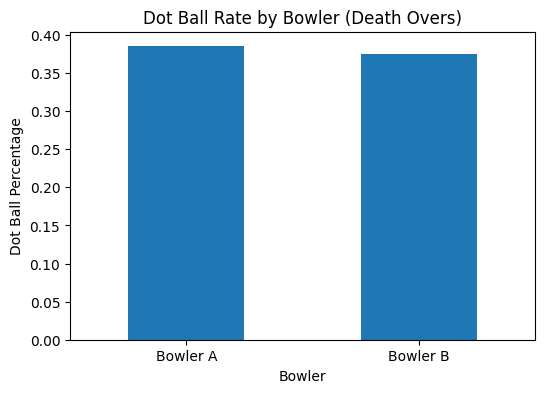

In [8]:
import matplotlib.pyplot as plt

dot_rates = df_death.groupby('Bowler')['Is_Dot_Ball'].mean()

plt.figure(figsize=(6,4))
dot_rates.plot(kind='bar')
plt.title("Dot Ball Rate by Bowler (Death Overs)")
plt.ylabel("Dot Ball Percentage")
plt.xlabel("Bowler")
plt.xticks(rotation=0)
plt.show()


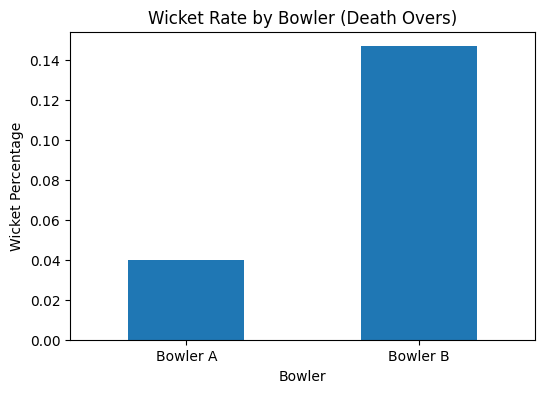

In [9]:
wicket_rates = df_death.groupby('Bowler')['Is_Wicket'].mean()

plt.figure(figsize=(6,4))
wicket_rates.plot(kind='bar')
plt.title("Wicket Rate by Bowler (Death Overs)")
plt.ylabel("Wicket Percentage")
plt.xlabel("Bowler")
plt.xticks(rotation=0)
plt.show()


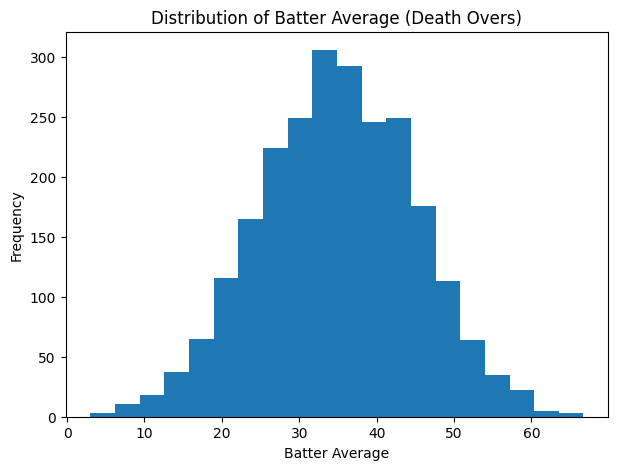

In [10]:
plt.figure(figsize=(7,5))
plt.hist(df_death['Batter_Avg'], bins=20)
plt.title("Distribution of Batter Average (Death Overs)")
plt.xlabel("Batter Average")
plt.ylabel("Frequency")
plt.show()


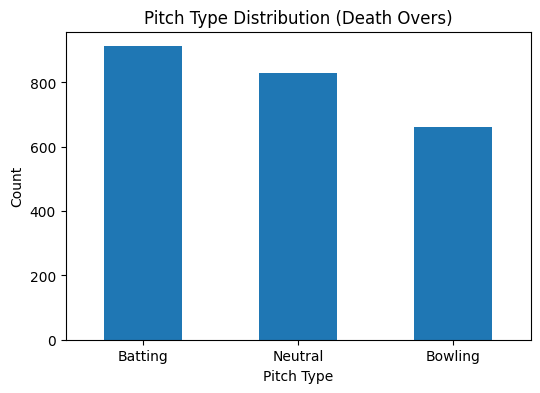

In [11]:
pitch_counts = df_death['Pitch_Type'].value_counts()

plt.figure(figsize=(6,4))
pitch_counts.plot(kind='bar')
plt.title("Pitch Type Distribution (Death Overs)")
plt.ylabel("Count")
plt.xlabel("Pitch Type")
plt.xticks(rotation=0)
plt.show()


PHASE 2

In [ ]:
import pymc as pm


In [ ]:
with pm.Model() as model:
    intercept = pm.Normal("intercept", 0, 1)
    betas = pm.Normal("betas", 0, 1, shape=X.shape[1])
    
    logits = intercept + pm.math.dot(X, betas)
    p = pm.Deterministic("p", pm.math.sigmoid(logits))
    
    y_obs = pm.Bernoulli("y_obs", p=p, observed=df_death['Is_Wicket'].values)
    
    trace = pm.sample(1000, tune=1000)

In [12]:
import pandas as pd

# Load dataset
df = pd.read_csv("C:\\Users\\skapi\\Desktop\\report\\IPL_Bowler_Detailed_Data.csv")

# -------------------------------
# 🔹 Step 1 — Feature Engineering
# -------------------------------

# Identify death overs (dataset already has Phase column)
df["is_death_over"] = df["Phase"].apply(lambda x: 1 if str(x).strip().lower() == "death" else 0)

# Dot ball = 0 runs conceded
df["is_dot_ball"] = df["Runs_Conceded"].apply(lambda x: 1 if x == 0 else 0)

# Pressure ball = dot ball + death overs + NOT 6th ball of over
df["pressure_ball"] = (
    (df["is_death_over"] == 1) &
    (df["is_dot_ball"] == 1) &
    (df["Ball"] != 6)          # prevent over-to-over pressure transfer
).astype(int)

# --------------------------------------
# 🔹 Step 2 — Check next ball wicket
# --------------------------------------

# Sort balls correctly for next-ball pairing
df = df.sort_values(by=["Match_ID", "Over", "Ball"]).reset_index(drop=True)

# Next ball wicket → shift Is_Wicket within the same match
df["next_ball_wicket"] = df.groupby("Match_ID")["Is_Wicket"].shift(-1).fillna(0).astype(int)

# Pressure → Next ball wicket
df["pressure_next_wicket"] = (
    (df["pressure_ball"] == 1) &
    (df["next_ball_wicket"] == 1)
).astype(int)

# --------------------------------------
# 🔹 Step 3 — Final Probability Metric
# --------------------------------------

total_pressure = int(df["pressure_ball"].sum())
wickets_after_pressure = int(df["pressure_next_wicket"].sum())

probability = (
    wickets_after_pressure / total_pressure
    if total_pressure > 0 else None
)

print("============== PHASE 1 SUMMARY ==============")
print(f"Total Pressure Balls: {total_pressure}")
print(f"Wickets Taken on Next Ball After Pressure: {wickets_after_pressure}")
print(f"Probability (Wicket | Pressure Ball): {probability:.4f}" if probability is not None else "Not enough data")
print("=============================================")

# --------------------------------------
# 🔹 Optional — Save engineered dataset
# --------------------------------------
'''df.to_csv(df.to_csv("new_file.csv", index=False))
print("\nEngineered dataset saved as:  Phase1_Engineered.csv")'''


============== PHASE 1 SUMMARY ==============
Total Pressure Balls: 772
Wickets Taken on Next Ball After Pressure: 144
Probability (Wicket | Pressure Ball): 0.1865


'df.to_csv(df.to_csv("new_file.csv", index=False))\nprint("\nEngineered dataset saved as:  Phase1_Engineered.csv")'

In [13]:
import pandas as pd

# Load dataset
df = pd.read_csv("C:\\Users\\skapi\\Desktop\\report\\new_file.csv")

# -------------------------------
# 🔹 Phase-1 Feature Engineering
# -------------------------------

# Identify death overs via Phase column
df["is_death_over"] = df["Phase"].apply(lambda x: 1 if str(x).strip().lower() == "death" else 0)

# Dot ball
df["is_dot_ball"] = df["Runs_Conceded"].apply(lambda x: 1 if x == 0 else 0)

# Pressure ball (dot ball + death + NOT 6th ball)
df["pressure_ball"] = (
    (df["is_death_over"] == 1) &
    (df["is_dot_ball"] == 1) &
    (df["Ball"] != 6)      # Pressure not applied across overs
).astype(int)

# Sort balls correctly for next-ball analysis
df = df.sort_values(by=["Match_ID", "Over", "Ball"]).reset_index(drop=True)

# Next ball wicket — inside each match
df["next_ball_wicket"] = df.groupby("Match_ID")["Is_Wicket"].shift(-1).fillna(0).astype(int)

# Pressure → next ball wicket
df["pressure_next_wicket"] = (
    (df["pressure_ball"] == 1) &
    (df["next_ball_wicket"] == 1)
).astype(int)

# ---------------------------------------
# 🔹 Per-Bowler Phase-1 Probability Table
# ---------------------------------------

bowler_summary = (
    df.groupby("Bowler")
      .agg(
          pressure_balls=("pressure_ball", "sum"),
          wickets_after_pressure=("pressure_next_wicket", "sum")
      )
      .reset_index()
)

bowler_summary["probability"] = (
    bowler_summary["wickets_after_pressure"] /
    bowler_summary["pressure_balls"].replace(0, pd.NA)
)

# Sort from most effective under pressure to least
bowler_summary = bowler_summary.sort_values(by="probability", ascending=False)

print("============ PER-BOWLER PHASE-1 RESULTS ============")
print(bowler_summary.to_string(index=False))

# ---------------------------------------
# 🔹 Save results as CSV
# ---------------------------------------
'''bowler_summary.to_csv("FENGG.csv", index=False)
print("\nSaved as  Phase1_Bowler_Analysis.csv")'''


============ PER-BOWLER PHASE-1 RESULTS ============
  Bowler  pressure_balls  wickets_after_pressure  probability
Bowler B             380                     133     0.350000
Bowler A             392                      11     0.028061


'bowler_summary.to_csv("FENGG.csv", index=False)\nprint("\nSaved as  Phase1_Bowler_Analysis.csv")'

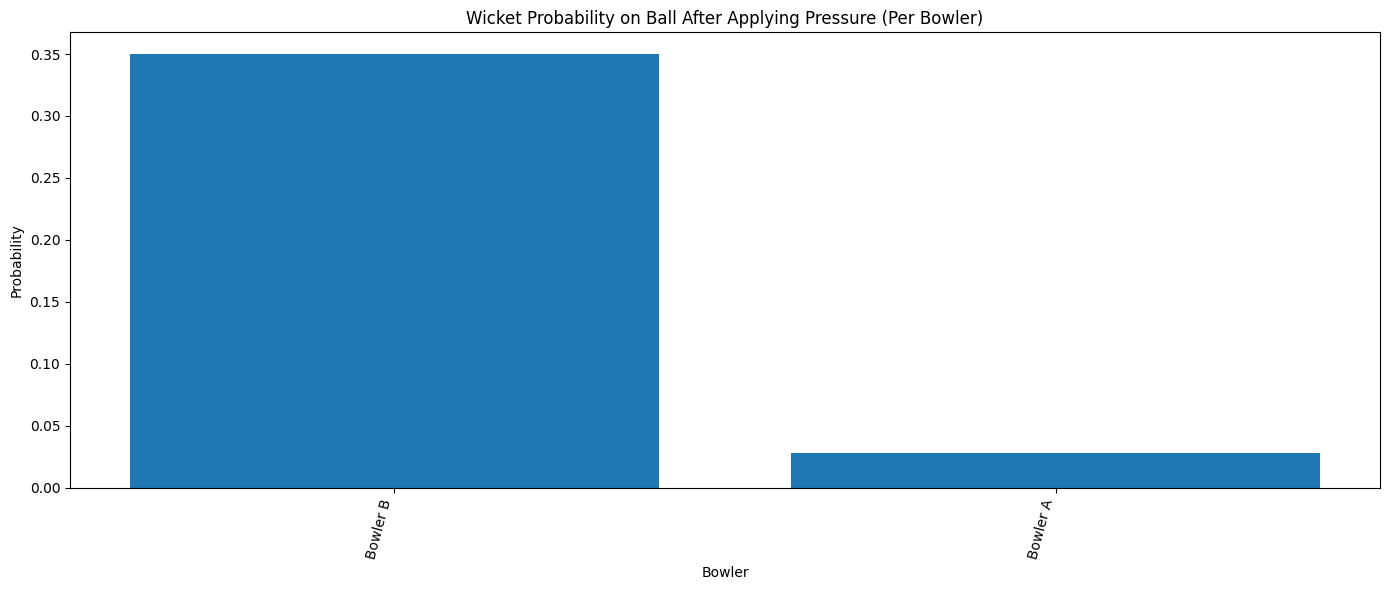

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.bar(bowler_summary["Bowler"], bowler_summary["probability"])
plt.xticks(rotation=75, ha="right")
plt.title("Wicket Probability on Ball After Applying Pressure (Per Bowler)")
plt.xlabel("Bowler")
plt.ylabel("Probability")
plt.tight_layout()
plt.show()

PHASE 3

In [15]:
import arviz as az

trace = az.from_netcdf("C:\\Users\\skapi\\Desktop\\report\\model_trace.nc")
print(trace)


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


In [16]:
import numpy as np

beta = trace.posterior["betas"].values.reshape(-1, 15)
pressure_effect = beta[:, 10]


In [17]:
pressure_A = beta[:, 10] + beta[:, 13]
pressure_B = beta[:, 10] + beta[:, 14]
pressure_diff = pressure_A - pressure_B

print("Mean pressure effect A:", pressure_A.mean())
print("Mean pressure effect B:", pressure_B.mean())
print("Mean difference (A - B):", pressure_diff.mean())
print("Probability(A > B):", (pressure_diff > 0).mean())

Mean pressure effect A: 3.8863986824708485
Mean pressure effect B: 4.244442473635451
Mean difference (A - B): -0.3580437911646031
Probability(A > B): 0.46375


Bowler A: mean = 0.057, 94% HDI = [-0.809, 0.912]
Bowler B: mean = 0.299, 94% HDI = [-0.658, 0.917]
Difference (B - A): mean = 0.242, 94% HDI = [-0.661, 1.403]
Probability(B > A | data) = 0.519


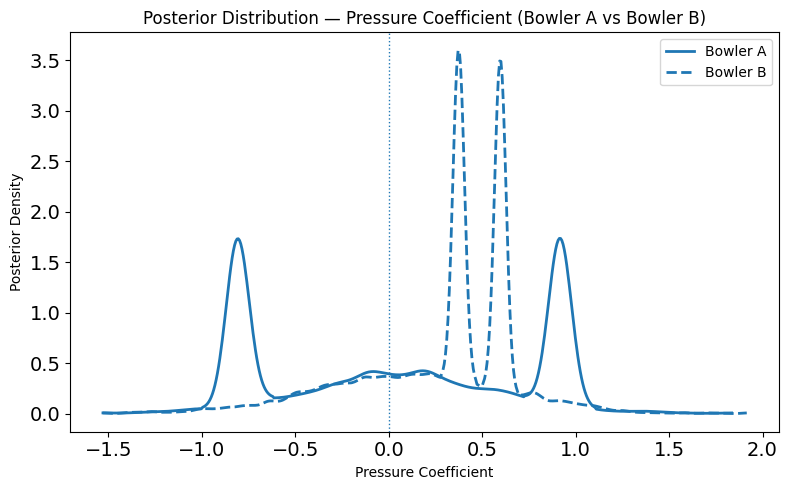

In [18]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# Extract posterior samples from the multivariate parameter "betas"
betas = trace.posterior["betas"].values  # shape: (chains, draws, 2)

# Bowler-specific posterior samples
pressure_A = betas[..., 0].flatten()   # Bowler A
pressure_B = betas[..., 1].flatten()   # Bowler B

# Compute 94% High Density Interval (HDI)
hdi_prob = 0.94
hdi_A = az.hdi(pressure_A, hdi_prob=hdi_prob)
hdi_B = az.hdi(pressure_B, hdi_prob=hdi_prob)

mean_A = pressure_A.mean()
mean_B = pressure_B.mean()

print(f"Bowler A: mean = {mean_A:.3f}, 94% HDI = [{hdi_A[0]:.3f}, {hdi_A[1]:.3f}]")
print(f"Bowler B: mean = {mean_B:.3f}, 94% HDI = [{hdi_B[0]:.3f}, {hdi_B[1]:.3f}]")

# Difference distribution (B - A)
diff = pressure_B - pressure_A
hdi_diff = az.hdi(diff, hdi_prob=hdi_prob)
mean_diff = diff.mean()
prob_B_greater = (diff > 0).mean()

print(f"Difference (B - A): mean = {mean_diff:.3f}, 94% HDI = [{hdi_diff[0]:.3f}, {hdi_diff[1]:.3f}]")
print(f"Probability(B > A | data) = {prob_B_greater:.3f}")

# Posterior Density Plot
plt.figure(figsize=(8, 5))
az.plot_kde(pressure_A, label="Bowler A", plot_kwargs={"linewidth": 2})
az.plot_kde(pressure_B, label="Bowler B", plot_kwargs={"linestyle": "--", "linewidth": 2})

plt.axvline(0, linestyle=":", linewidth=1)
plt.xlabel("Pressure Coefficient")
plt.ylabel("Posterior Density")
plt.title("Posterior Distribution — Pressure Coefficient (Bowler A vs Bowler B)")
plt.legend()
plt.tight_layout()
plt.show()
